In [5]:
# solving the black jack game described in example 5.1 of Sutton Barto

using Random, StatsBase

# the face values for a suit
# ace through nine, ten, jack, queen, king
# note that 1=ace
suit = vcat(1, collect(2:9), 10, 10, 10, 10)


deck = repeat(suit, 4)
shuffle!(deck)     # a random permutation


deal_cards(n) = sample(deck, n, replace=true)


usable_ace(hand) = (any(hand .== 1) && sum(hand) <= 11) ? 2 : 1

score(hand) = sum(hand) + (usable_ace(hand)==2 ? 10 : 0)


function blackjack(policy, ε = 0.05)
    player = deal_cards(2)
    dealer = deal_cards(2)

    a = 1
    

    while score(player) < 12
       append!(player, deal_cards(1)) 
    end

    states = [[score(player), dealer[2], usable_ace(player)]]
    actions = []

    if score(player) == 21
        a = 2
        append!(actions, 2)
        if score(dealer) == 21
            return states, actions, 0.0
        else
            return states, actions, 1.0
        end
    end
    
    # player does not have natural, so player's turn
    while true

        # determine action according to policy
        i = usable_ace(player)
        a = policy[score(player)-11, dealer[2], i]

        if rand() < ε  # with probability ϵ take the non-optimal action
            a = 3 - a  # change 2 to 1, or change 1 to 2
        end
        
        if a==2  # stick
            append!(actions, 2)
            break
        else     # hit
            append!(actions, 1)
            append!(player, deal_cards(1))
            if score(player) > 21
                return states, actions, -1.0 # player went bust
                # note that in the case of a bust we do not append the
                # "busted" state.  when the player goes "bust", the
                # agent needs to "learn" that taking a hit from that
                # pre-bust state leads to a reward of -1.
            else
                push!(states, [score(player), dealer[2], usable_ace(player)])
            end
        end
    end

    while score(dealer) < 17
        append!(dealer, deal_cards(1)) 
    end
    
    if score(dealer) > 21 || score(player) > score(dealer)
        r = 1.0
    elseif score(player) < score(dealer)
        r = -1.0
    else
        r = 0
    end
    
    return states, actions, r
end

# this is on-policy every-visit MC control because we do not check for
# 1st visits to states; however, for the game of blackjack, it's not
# possible to visit the same state twice in an episode. you could have
# an ace being counted as 11, and then later being counted as 1, but
# the indicator for a usable ace is part of the state.  also, note
# that we maintain exploration of nonoptimal actions in the function
# blackjack().
function MC!(q, qn, policy)
    for i = 1:10e4
        i % 100000 == 0 && println("episode ", i)
        states, actions, r = blackjack(policy)
        @assert(length(states) == length(actions))
        @assert( r in [-1.0, 0.0, 1.0])
        T = length(states)
        for t = 1:T
            # since this is every-visit MC, the reward at the end
            # of the episode is the return for each state visited, and
            # there is no discounting, the direction of iteration over
            # the episode should not matter.
            
            pl = states[t][1] - 11
            de = states[t][2]
            us = states[t][3]
            ac = actions[t]
            qn[pl,de,us,ac] += 1
            q[pl,de,us,ac] += (r - q[pl,de,us,ac])/qn[pl,de,us,ac]


            allidx = findall(q[pl,de,us,:] .== maximum(q[pl,de,us,:]))
            @assert(allidx in [ [1], [2], [1,2] ])
            if length(allidx) > 1
                idx = sample(allidx, 1)[1]
            else
                idx = allidx[1]
            end
            policy[pl,de,us] = idx

        end
    end
end

# the state space consists of
# the player's sum 12:21,
# the dealer's showing card 1:10,
# and indicator for usable ace no/yes=1/2
# for a total of 200 possible states.
# the action is hit/stick=1/2

# the initial policy is to stick when the player's sum is 20 or 21, otherwise hit
policy = fill(1, (10, 10, 2))
policy[9:10,:,:] .= 2           # stick when sum is 20 or 21
q = zeros(10, 10, 2, 2)    # q(state=(player,dealer,usable), action)
qn = zeros(10, 10, 2, 2)   # to hold the number of observations

MC!(q, qn, policy)

episode 100000.0


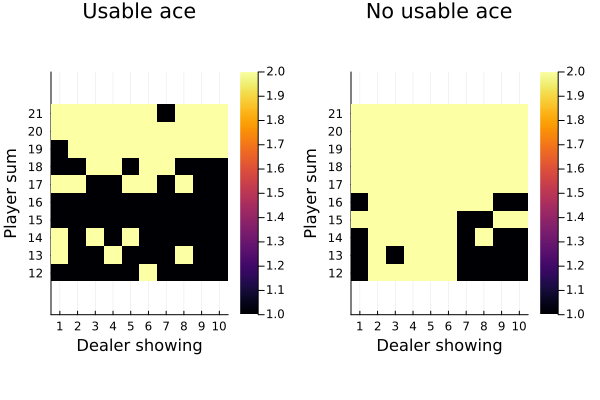

In [6]:
using Plots
player_string = [string(i) for i = 12:21]  
dealer_string = [string(i) for i = 1:10]

z = policy[:,:,2]
pl1 = heatmap(dealer_string, player_string, z,
              aspect_ratio=1,
              xlabel="Dealer showing",
              ylabel="Player sum",
              title="Usable ace",
              fmt=:png)
z = policy[:,:,1]
pl2 = heatmap(dealer_string, player_string, z,
              aspect_ratio=1,
              xlabel="Dealer showing",
              ylabel="Player sum",
              title="No usable ace",
              fmt=:png)
plot(pl1,pl2)




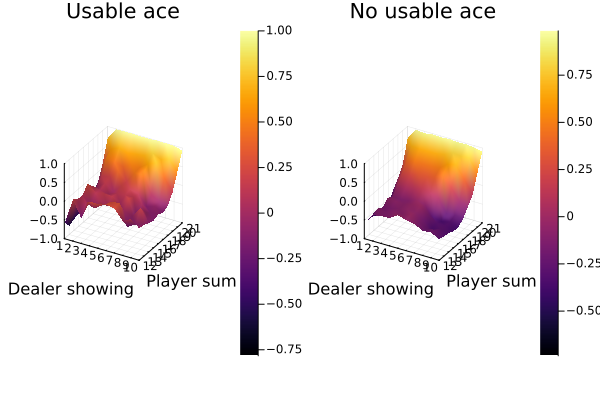

In [7]:
# obtain the state-value function v from the action-value function q
v = zeros(10, 10, 2)
for pl = 1:size(q)[1]
    for de = 1:size(q)[2]
        for us = 1:size(q)[3]
            v[pl,de,us] = findmax(q[pl,de,us,:])[1]
        end
    end
end
# plot the state-value function
pl3 = surface(dealer_string, player_string, v[:,:,2],
              xlabel = "Dealer showing",
              ylabel = "Player sum",
              title = "Usable ace",
              zlims = (-1.0,1.0))
pl4 = surface(dealer_string, player_string, v[:,:,1],
              xlabel = "Dealer showing",
              ylabel = "Player sum",
              title = "No usable ace",
              zlims = (-1.0,1.0))
plot(pl3,pl4)

In this project I had to implement the blackjack function as well as the mc! function. It uses the already provided functions deal_cards and usable_ace for its calculations. There isn't a lot to explain for it... It's just a stripped down version of blackjack. It first deals the cards to both the player and dealer, hits until the player score is >12. Once the player has that, it checks if the dealer or player has 21, if they don't, we set up a while loop that makes decicions based off policy. Once that's completed, we compute the dealers turn for the rewards. In the next function, the goal of MC! is every-visit MC control for the blackjack function. I follow the pseudo code in sutton-barto page 101, which is an on-policy first-visit mc control for epsilon soft policies.